# Trajectory analysis per single track
The notebook loads 2D trajectory data, applies Savitzky-Golay smoothing, computes instantaneous and windowed features (speed, angular velocity, etc), and classifies behavioral states (Swim, Reorient, Reverse) based on deviation angle variance.

Input:
- folder_main: Path to the main data folder containing the trajectory file
- npy_file: Name of the input NumPy file with trajectory data
- fps: Frames per second of the recording
- px_mm: Conversion factor from pixels to millimeters
- Smoothing and feature extraction parameters (e.g., window sizes, thresholds)

Output:
- figures (PNG, SVG) of trajectories and state ethograms
- CSV files with time series of calculated features and state labels

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from scipy.signal import savgol_filter
from scipy.optimize import least_squares
from scipy.stats import circvar
import csv
import pandas as pd
# %matplotlib widget
%matplotlib inline

import matplotlib as mpl
# Ensure text is saved as editable text in SVG
mpl.rcParams['svg.fonttype'] = 'none'
# Set global font to Arial
mpl.rcParams['font.family'] = 'Arial'

Define input:

In [2]:
# Path to main data folder:
folder_main = "W:\\Users\\Daphne\\Imaging_Daphne\\25-12-19_RPi_ptetwt_swimming_deciliated\\bgd_subs_4000\\processed_251219_etoh_allcilia_3_analysis\\"

# input/output paths and files:
npy_file = "filtered_trajectories_2.npy"
sample_nr = "_allcilia_3" # used to name output files
file_path = folder_main + npy_file
output_path =  folder_main
fps = 30

# track_data = pd.read_csv(file_path)
track_array = np.load(file_path, allow_pickle=True)
# track_data = pd.DataFrame(track_array[0], columns=['x', 'y'])
track_data = pd.DataFrame(track_array, columns=['x', 'y'])

#OPTIONAL: Limit the number of rows for testing purposes
# track_data = track_data[:1000]  # Limit to first 1000 rows for testing 

# Define the conversion to mm:
px_mm = 91.8 # 91.8 pixels = 1 mm

Quick check that the data is read correctly:

In [3]:
track_data

,x,y
0,1322.651044,495.758578
1,1321.120051,495.831290
2,1319.313517,495.680087
3,1317.476291,495.880610
4,1314.418631,495.766999
...,...,...
1196,816.217978,947.158565
1197,816.998230,946.836814
1198,818.740728,946.542599
1199,820.483226,946.248384


Visualize the track to compare later with the smoothed version:

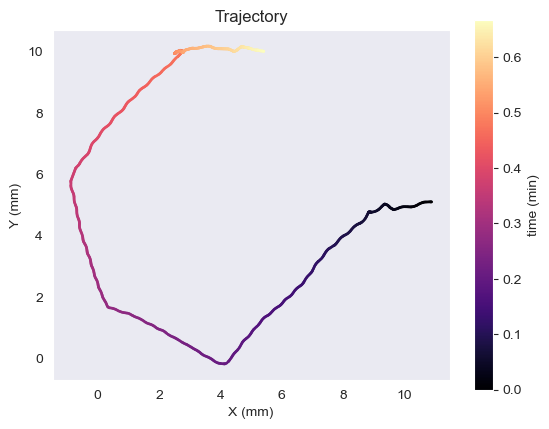

In [4]:
# Extract x, y, and time coordinates from the data:
x = track_data['x'] / px_mm
y = track_data['y'] / px_mm
time = pd.Series(track_data.index) / 30  # 30 fps, assuming the index represents the frame number
time = (time - time.iloc[0])/60  # divsion by 60 to get the time in min
    
# For nicer display the following translates the data to be in a range of positive x and y
# 1. Finds the center of the current data:
center_x = (np.min(x) + np.max(x)) / 2
center_y = (np.min(y) + np.max(y)) / 2
# 2. Choose a target center:
target_center_x, target_center_y = 5,5
# 3. Calculate the translation:
translation_x = target_center_x - center_x
translation_y = target_center_y - center_y
# 4. Apply the translation:
translated_x = x + translation_x
translated_y = y + translation_y
    
# Plots the trajectory for visualization:
plt.figure()
plt.scatter(translated_x, translated_y, c=time, cmap="magma", s=1) # Plot the data points with color representing time
plt.colorbar(label='time (min)')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Trajectory')
plt.grid(False)
plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig(output_path + "trajectory_no_correction.png", dpi=300, bbox_inches='tight')
plt.show()

Make convenient arrays to work with later:

In [5]:
# Combines the x and y coorinates in an array:
translation_x_array = translated_x.to_numpy()
translation_y_array = translated_y.to_numpy()
translations = np.column_stack((translation_x_array, translation_y_array))

# Prepares the time axis in seconds for the plots:
time_steps = (np.diff(time.to_numpy()).reshape(-1, 1)) * 60   # this is should just be the step between frames in seconds
time_axis_sec = np.cumsum(time_steps)                         # this should be the timestamps starting from 0 in seconds
time_axis_sec_with_0 = np.insert(time_axis_sec, 0, 0)

## 1. Noise estimation and trajectory smoothing:

#### We need to remove noise (e.g. from tracking) but preserve the features and transition in the data. 

(Roughly reorientations take about 1/2 sec to complete. Smoothing window should not be larger than that. Note that we sample with 30 fps, therefore the window size should be about 9-15 frames.)
Avoid moving average because it will not preserve features. A filter that includes polynomial fitting is best e.g. Savitzky-Golay.

**Savitzky-Golay filter**: preserves features like peaks or rapid changes in the trajectory. It works by fitting successive polynomial functions to small, overlapping windows of the data. The degree of smoothing can be tuned using window_length and polyorder.
Note that since it preserves features the window can be slightly bigger than the dynamics we anticipate.


In [6]:
# Target window size for the trajectory smoothing:
target_window_smoothing = 1/2  # in sec!   If we want in terms of points (should be odd number),
window_smoothing_SG = int(np.ceil(target_window_smoothing * fps))
window_smoothing_SG_odd = window_smoothing_SG if window_smoothing_SG % 2 != 0 else window_smoothing_SG + 1
print("chosen window size: ", int(window_smoothing_SG_odd))

chosen window size:  15


Below we plot the x and y coordinates and the cumulative distance before and after the smoothing to check if we indeed preserve features while reducing noise or the window is to big/small

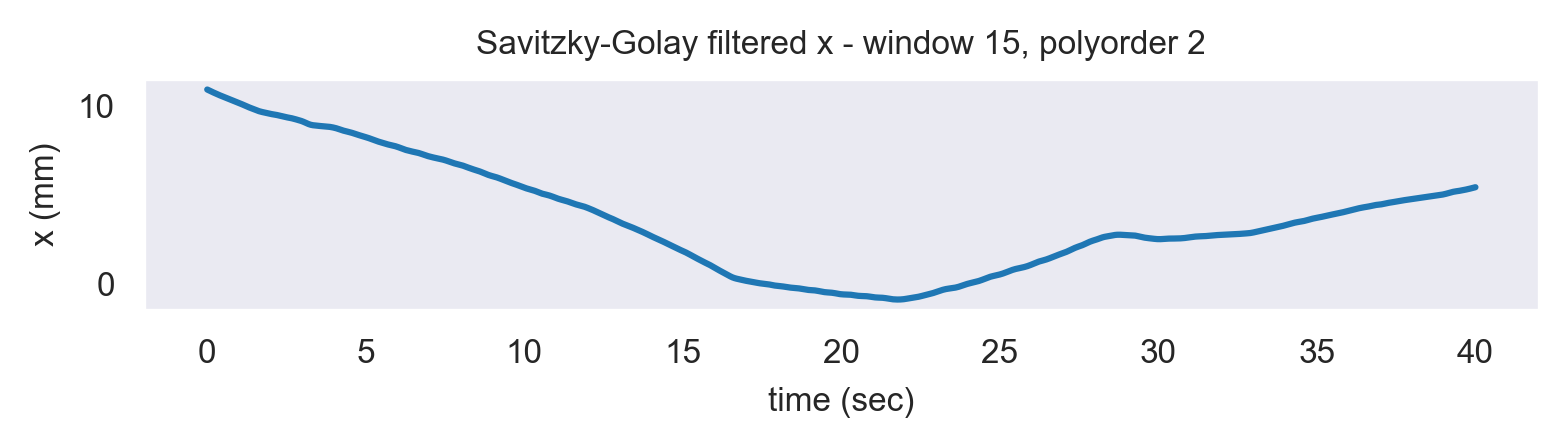

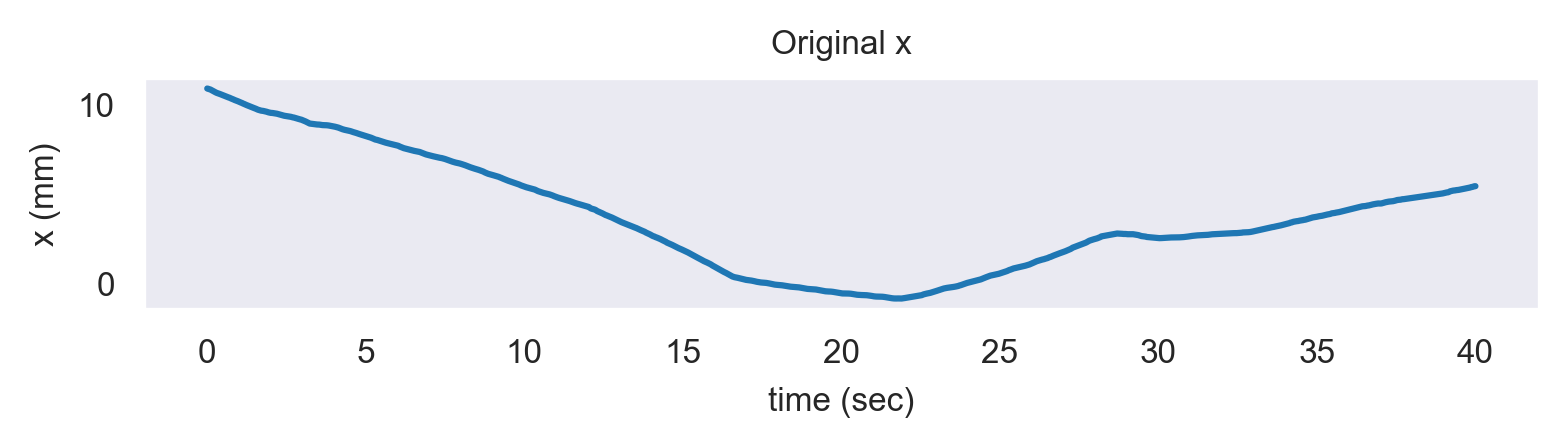

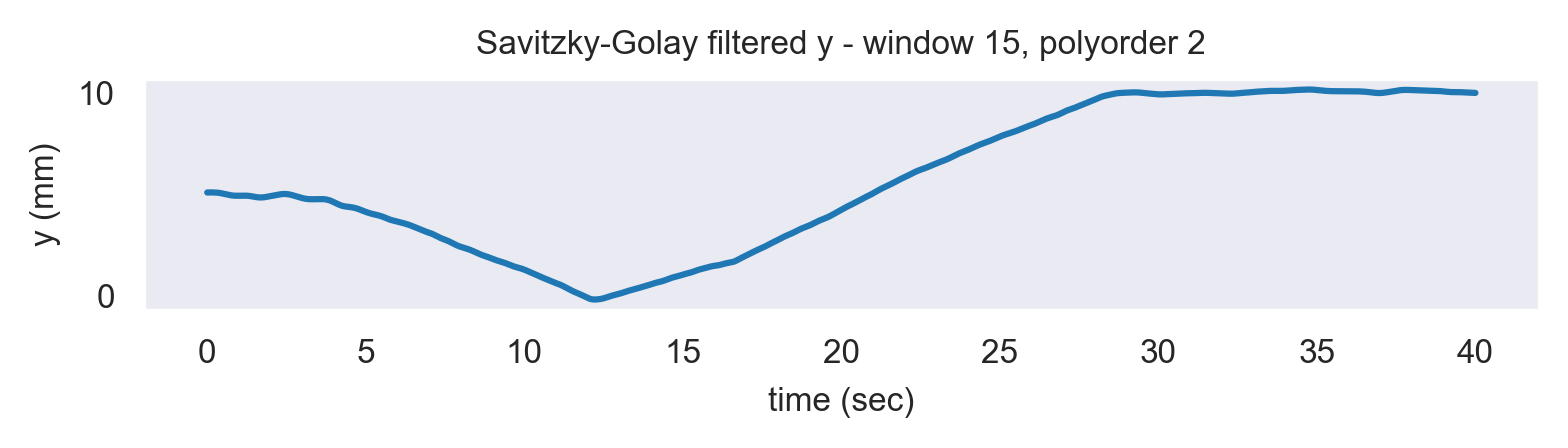

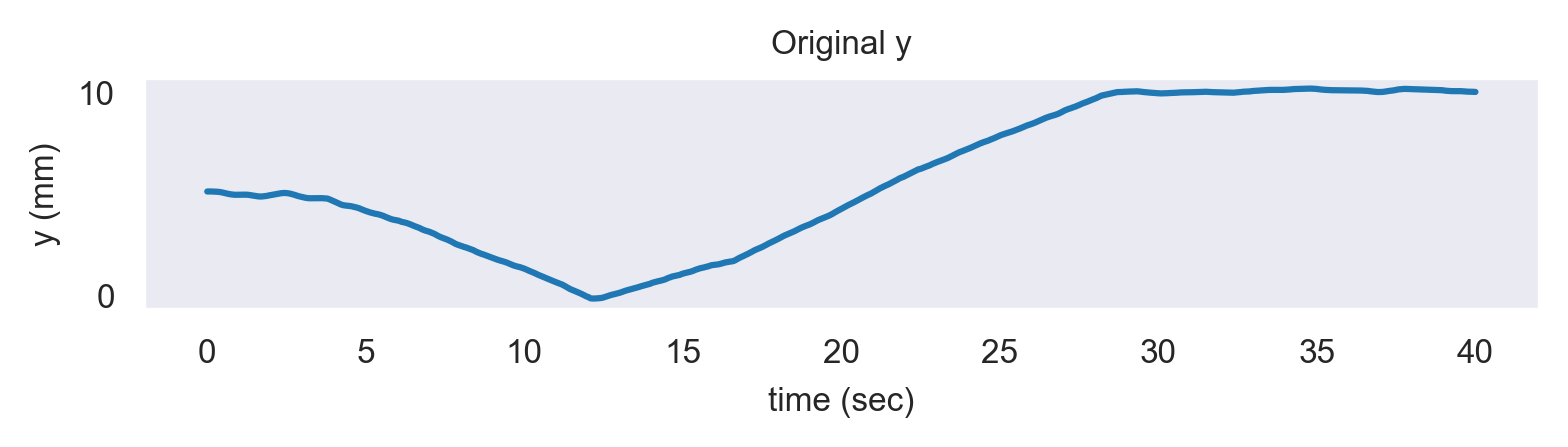

In [7]:
# Track smoothing with Savitzky-Golay
t = time_axis_sec_with_0
noisy_signal_x = translations[:,0]   
noisy_signal_y = translations[:,1]

# 1. Apply Savitzky-Golay filter
window_length = window_smoothing_SG_odd  # It has to be an odd number! Set to 7 for 0.5 sec
polyorder = 2       # Usually 2 or 3 
smoothed_x = savgol_filter(noisy_signal_x, window_length, polyorder)
smoothed_y = savgol_filter(noisy_signal_y, window_length, polyorder)
smoothed_translations = np.column_stack((smoothed_x, smoothed_y))

# 2. Plot result
fontsize_1 = 8
plt.figure(figsize = (6,1),dpi=300)
plt.ylabel("x (mm)", fontsize = fontsize_1)
plt.xlabel("time (sec)", fontsize = fontsize_1)
plt.xticks(fontsize = fontsize_1)
plt.yticks(fontsize = fontsize_1)
plt.plot(t, smoothed_x, label="Smoothed Data")
plt.title("Savitzky-Golay filtered x - window " + str(window_length) + ", polyorder " + str(polyorder), fontsize = fontsize_1)
plt.grid()
# plt.savefig(output_path + "x_in_time_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize = (6,1),dpi=300)
plt.ylabel("x (mm)", fontsize = fontsize_1)
plt.xlabel("time (sec)", fontsize = fontsize_1)
plt.xticks(fontsize = fontsize_1)
plt.yticks(fontsize = fontsize_1)
plt.plot(t, noisy_signal_x, label="Noisy data")
plt.title("Original x", fontsize = fontsize_1)
plt.grid()
# plt.savefig(output_path + "x_in_time_raw.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize = (6,1),dpi=300)
plt.ylabel("y (mm)", fontsize = fontsize_1)
plt.xlabel("time (sec)", fontsize = fontsize_1)
plt.xticks(fontsize = fontsize_1)
plt.yticks(fontsize = fontsize_1)
plt.plot(t, smoothed_y, label="Smoothed Data")
plt.title("Savitzky-Golay filtered y - window " + str(window_length) + ", polyorder " + str(polyorder), fontsize = fontsize_1)
plt.grid()
# plt.savefig(output_path + "y_in_time_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize = (6,1),dpi=300)
plt.ylabel("y (mm)", fontsize = fontsize_1)
plt.xlabel("time (sec)", fontsize = fontsize_1)
plt.xticks(fontsize = fontsize_1)
plt.yticks(fontsize = fontsize_1)
plt.plot(t, noisy_signal_y, label="Noisy data")
plt.title("Original y", fontsize = fontsize_1)
plt.grid()
# plt.savefig(output_path + "y_in_time_raw.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

#### Main trajectory parameters are calculated below. Noting that abrupt peaks appear due to single points, we can apply a mean average with a small window to reduce the noise.

Instantaneous velocity and its amplitude (speed):

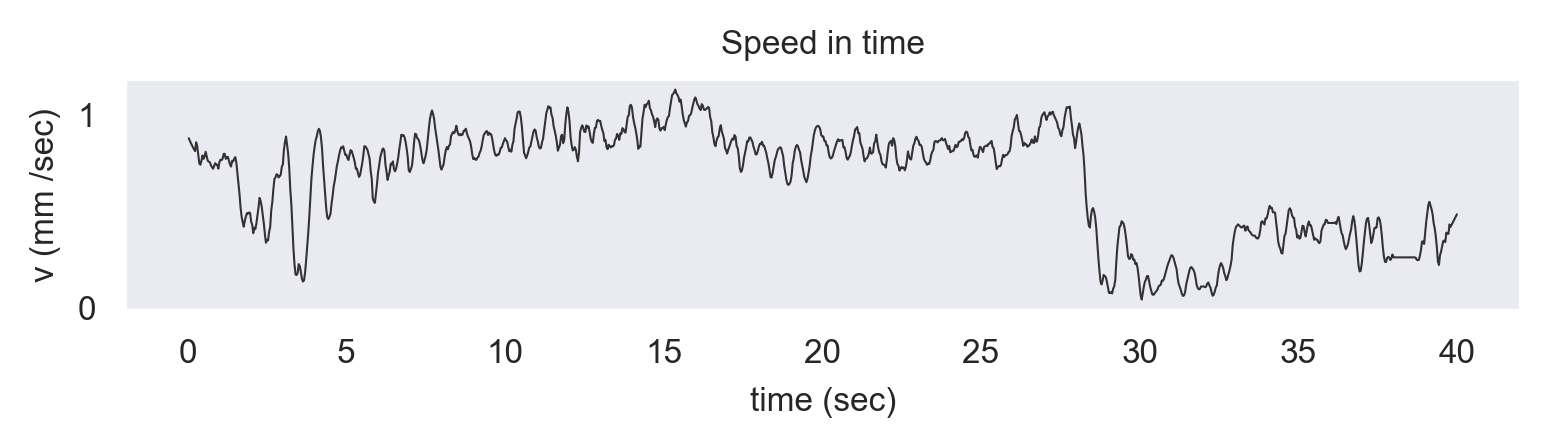

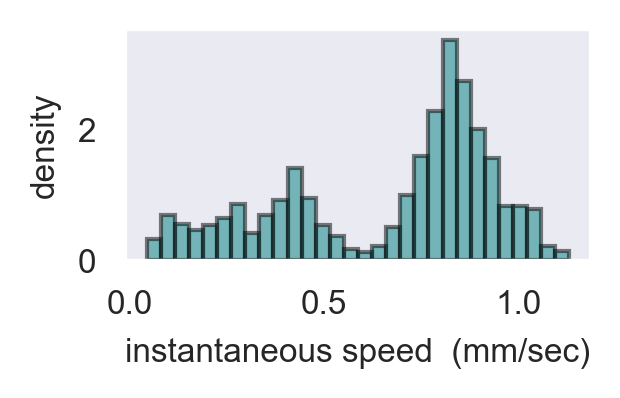

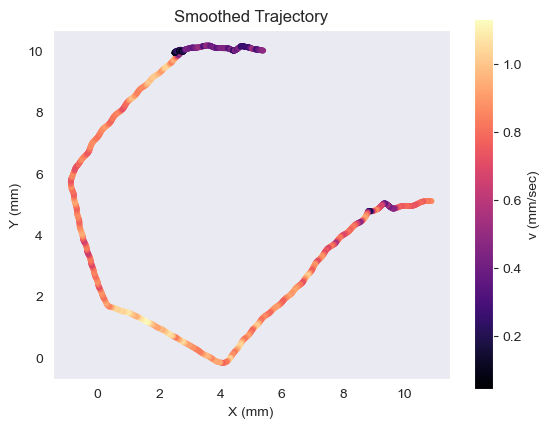

In [8]:
### Calculate instantaneous linear velocity and speed:
translations_to_analyze = smoothed_translations  # if you want to check with the raw trajectory set: translations_to_analyze =translations
velocities = []
velocities = np.diff(translations_to_analyze, axis = 0) / time_steps
speed_cell = np.linalg.norm(velocities, ord=2,  axis=1) 


# 1. Time evolution:
plt.figure(figsize = (6,1),dpi=300)
plt.plot(time_axis_sec,speed_cell, color='0.2', linewidth=0.5) #,alpha=0.7)
# plt.plot(time_axis_sec, speed_cell_smooth, label='Smoothed Speed', color='orange', linewidth=2)
plt.title("Speed in time", fontsize = fontsize_1)
plt.ylabel("v (mm /sec)", fontsize = fontsize_1)
plt.xlabel("time (sec)", fontsize = fontsize_1)
plt.xticks(fontsize = fontsize_1)
plt.yticks(fontsize = fontsize_1)
plt.grid(False)
plt.savefig(output_path + "instantaneous_speed_in_time_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig(output_path + "instantaneous_speed_in_time_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".svg", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# 2. Histogram:
fontsize_2 = 8
plt.figure(figsize=(2, 1),dpi=300)
plt.hist(speed_cell, bins=30, density=True, alpha=0.5, color='teal', edgecolor='black', label='data')
plt.ylim()
plt.xlabel('instantaneous speed  (mm/sec)', fontsize = fontsize_2)
plt.ylabel('density', fontsize = fontsize_2)
plt.xticks(fontsize = fontsize_2)
plt.yticks(fontsize = fontsize_2)
plt.grid(False)
# plt.savefig(output_path + "instantaneous_speed_histogram_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# 3. Color coding the track:
plt.figure()
# Plot the data points with color representing time
plt.scatter(translations_to_analyze[:-1,0], translations_to_analyze[:-1,1], c= speed_cell, cmap="magma", s=10)
plt.colorbar(label='v (mm/sec)')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Smoothed Trajectory')
plt.grid(False)
plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig(output_path + "trajectory_speed_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Extracting additional metric: DAV

This metric is calculated for a given window in time.

In [29]:
### Calculate instantaneous angles and reorientation:
dot_product = np.sum(velocities[:-1, :] * velocities[1:, :], axis=1)
norms_prev = np.linalg.norm(velocities[:-1, :], axis=1)
norms_next = np.linalg.norm(velocities[1:, :], axis=1)
denominator = np.clip(norms_prev * norms_next, a_min=1e-18, a_max=None)
cosine_of_consequetive_angle = dot_product / denominator
# # Angle from 0 to π
angles = np.arccos(np.clip(cosine_of_consequetive_angle, -1.0, 1.0))
# Correction to have it from -π to +π:
cross_product_z = (velocities[:-1, 0] * velocities[1:, 1] -
                   velocities[:-1, 1] * velocities[1:, 0])
# Adjust angle based on cross product sign
signed_angles_in_rad = np.where(cross_product_z >= 0, angles, -angles)
signed_angles_in_deg = np.degrees(signed_angles_in_rad)
absolute_signed_angles_in_rad = np.abs(signed_angles_in_rad)
absolute_signed_angles_in_deg = np.abs(signed_angles_in_deg)

def compute_features_for_window_size(trajectory, velocities, speed_cell, signed_angles_in_rad, window_size):
        current_trajectory = trajectory # .smoothed_trajectory[1:-1, :]
        variance_in_directionality = []
        
        for i in range(current_trajectory.shape[0]):
            # Step 1: Determine loop boundaries
            start = max(0,  i - window_size//2)
            end = min(current_trajectory.shape[0], i + window_size//2)

            # Correct the endpoints if they're outside the [0, b] interval while keeping n iterations
            if start == 0:
                end = min(current_trajectory.shape[0], start + window_size) 
            elif end == current_trajectory.shape[0]:
                start = max(0, end - window_size)

            xy = current_trajectory[start:end, :]  # Use all columns (x, y)
            variance_in_directionality.append(circvar(signed_angles_in_rad[start:end], high=np.pi, low=-np.pi))

        return pd.DataFrame({
                            f'{window_size}_DAV' : np.asanyarray(variance_in_directionality),
                            })

Window size should not exceed the expected dynamics timescales too much

In [30]:
target_window_features = 1/2  # in sec
window_features = int(np.ceil(target_window_features * fps))
window_features_odd = window_features if window_features % 2 != 0 else window_features + 1
track_features = compute_features_for_window_size(translations_to_analyze, velocities, speed_cell, signed_angles_in_rad,  window_features_odd)

dav  = track_features[str(window_features_odd) + '_DAV']

Plotting results for DAV:

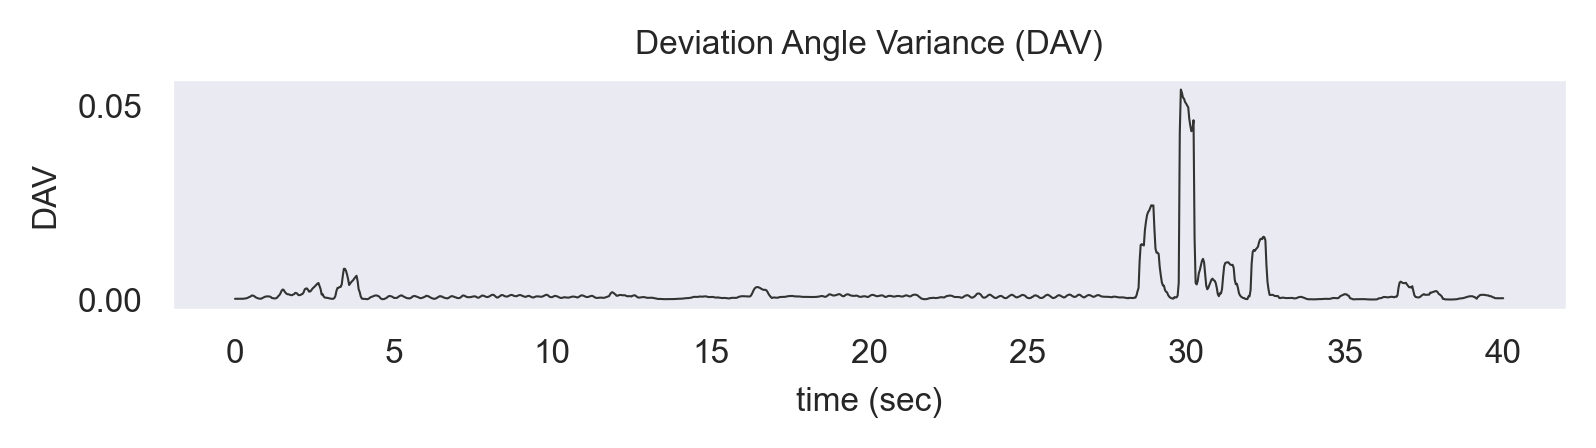

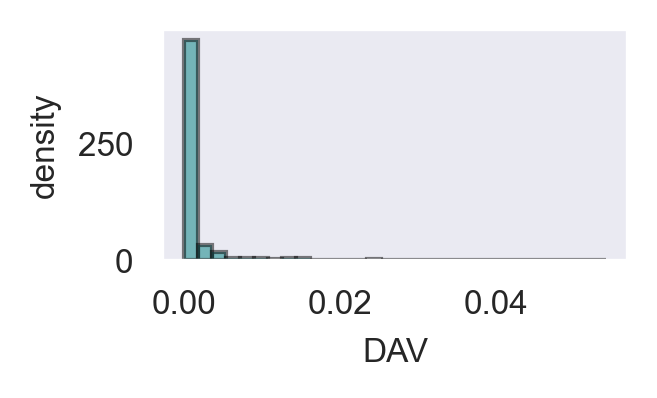

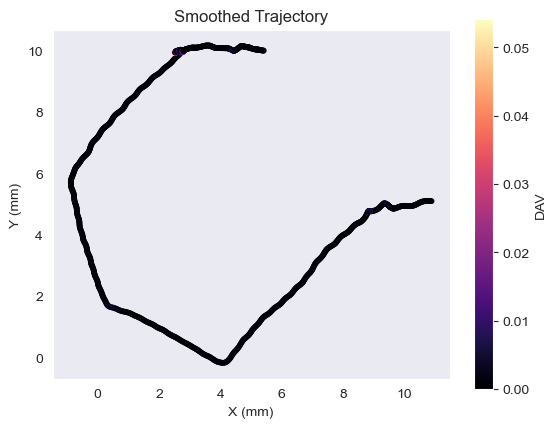

In [31]:
# DAV
dav_array = dav.to_numpy()
dav_array = dav_array.reshape(1, -1)[0]

# 1. Time evolution:
plt.figure(figsize = (6,1),dpi=300)
plt.plot(time_axis_sec_with_0, dav_array, color='0.2', linewidth=0.5)
plt.title("Deviation Angle Variance (DAV)", fontsize = fontsize_1)
plt.ylabel("DAV", fontsize = fontsize_1)
plt.xlabel("time (sec)", fontsize = fontsize_1)
plt.xticks(fontsize = fontsize_1)
plt.yticks(fontsize = fontsize_1)
plt.grid(False)
plt.savefig(output_path + "dav_in_time_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig(output_path + "dav_in_time_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".svg", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# 2. Histogram:
fontsize_2 = 8
plt.figure(figsize=(2, 1),dpi=300)
plt.hist(dav_array, bins=30, density=True, alpha=0.5, color='teal', edgecolor='black', label='data')
plt.ylim()
plt.xlabel('DAV', fontsize = fontsize_2)
plt.ylabel('density', fontsize = fontsize_2)
plt.xticks(fontsize = fontsize_2)
plt.yticks(fontsize = fontsize_2)
plt.grid(False)
plt.savefig(output_path + "dav_histogram_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# 3. Color coding the track:
plt.figure()
# Plot the data points with color representing time
plt.scatter(translations_to_analyze[:,0], translations_to_analyze[:,1], c= dav_array, cmap="magma", s=10)
plt.colorbar(label='DAV')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Smoothed Trajectory')
plt.grid(False)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(output_path + "trajectory_dav_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

Save all relevant data calculated above.

In [32]:
def save_output_csv(output_file, velocity_x, velocity_y, speed,signed_angles_in_deg, translation_x, translation_y, dav):
    """
    Save the size and center of the cell in an csv file.
    """
    # Check if the file exists
    file_exists = os.path.exists(output_file)

    new_signed_angles_in_deg = np.concatenate(([0], signed_angles_in_deg))
    # Ensure all arrays have the same length
    n = len(velocity_x)
    assert len(velocity_y) == n
    assert len(speed) == n
    assert len(translation_x) == n
    assert len(translation_y) == n
    assert len(time_axis_sec) == n
    
    
    with open(output_file, mode='a' if file_exists else 'w', newline='') as file:
        writer = csv.writer(file)
    
        # Write header if the file is newly created
        if not file_exists:
            writer.writerow(['velocity_x (mm/sec)', 'velocity_y (mm/sec)', ' speed (mm/sec)', 'signed_angles_in_deg', 'translation_x (mm)', 'translation_y (mm)', 'dav'])
    
        # Write data to CSV
        for i in range(n):
            writer.writerow([velocity_x[i], velocity_y[i], speed[i], new_signed_angles_in_deg[i], translation_x[i], translation_y[i], dav[i]])

    return

# output_path = main_path +"results\\" +"_basic_measurements.csv"
output_path_csv = os.path.join(output_path ,"basic_measurements_SG" + str(window_length) + "_" +  str(polyorder) + ".csv")
save_output_csv(output_path_csv, velocities[:,0], velocities[:,1], speed_cell, signed_angles_in_deg, translations_to_analyze[:-1,0], translations_to_analyze[:-1,1], dav_array)

## Identifying states

First apply a mean filter with very small window on the linear and angular velocity and then recalculate some metrics using that to decide on the classification criteria. Then set thresholds for the states of interest (for Paramecium the DAV is used) and identify the borders of each segment of the classified track. Using those indices the corresponding segments are separated and can be studied in isolation.

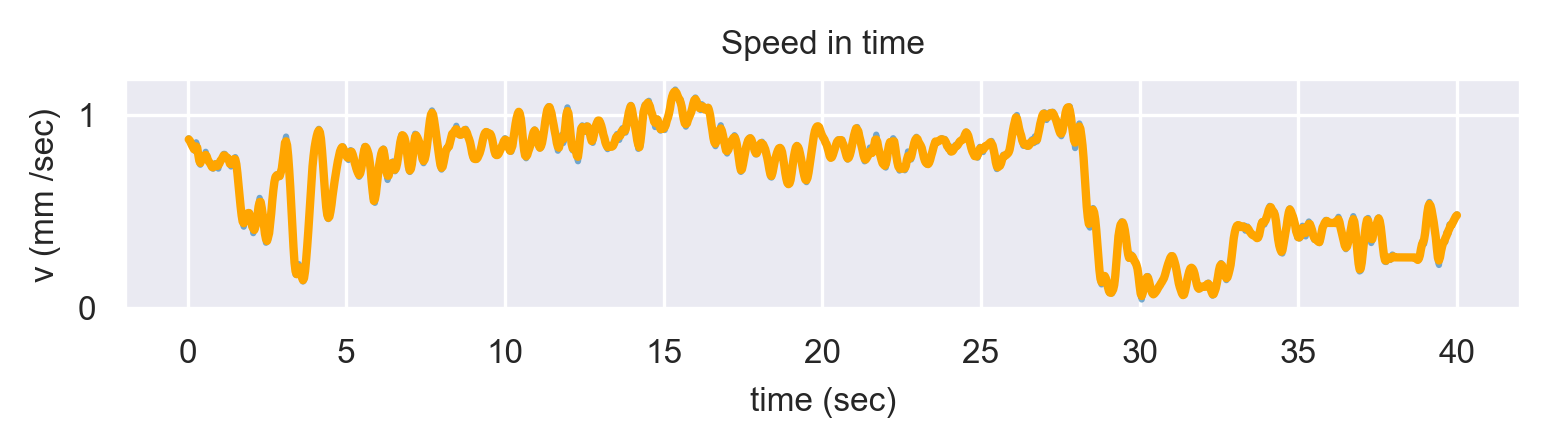

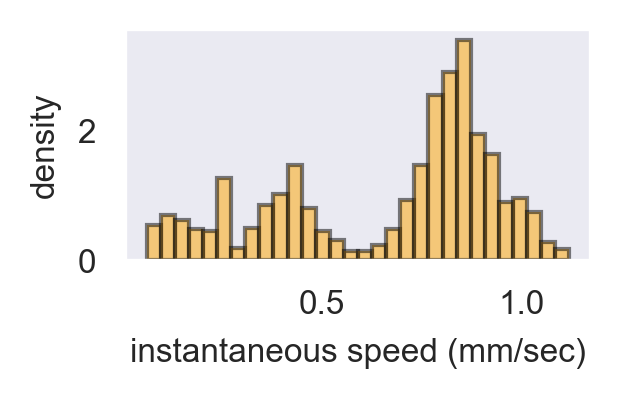

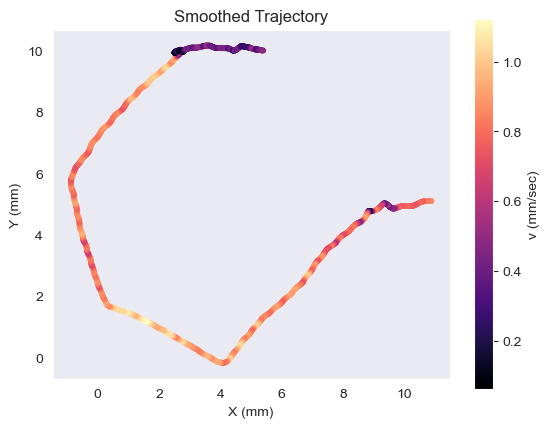

In [34]:
### Calculate instantaneous linear velocity and speed:
window_size_mov_av = 3  # keep it very small
speed_series = pd.Series(speed_cell)
speed_cell_smooth = speed_series.rolling(window=window_size_mov_av, center=True, min_periods=1).mean()

# 1. Time evolution:
plt.figure(figsize = (6,1),dpi=300)
plt.plot(time_axis_sec,speed_cell, alpha=0.6)
plt.plot(time_axis_sec, speed_cell_smooth, label='Smoothed Speed', color='orange', linewidth=2)
plt.title("Speed in time", fontsize = fontsize_1)
plt.ylabel("v (mm /sec)", fontsize = fontsize_1)
plt.xlabel("time (sec)", fontsize = fontsize_1)
plt.xticks(fontsize = fontsize_1)
plt.yticks(fontsize = fontsize_1)
plt.grid(True)
plt.savefig(output_path + "instantaneous_speed_mov_av_in_time_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# 2. Histogram:
fontsize_2 = 8
plt.figure(figsize=(2, 1),dpi=300)
plt.hist(speed_cell_smooth, bins=30, density=True, alpha=0.5, color='orange', edgecolor='black', label='data')
plt.ylim()
plt.xlabel('instantaneous speed (mm/sec)', fontsize = fontsize_2)
plt.ylabel('density', fontsize = fontsize_2)
plt.xticks(fontsize = fontsize_2)
plt.yticks(fontsize = fontsize_2)
plt.grid(False)
plt.savefig(output_path + "instantaneous_speed_mov_av_histogram_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# 3. Color coding the track:
plt.figure()
# Plot the data points with color representing time
plt.scatter(translations_to_analyze[:-1,0], translations_to_analyze[:-1,1], c= speed_cell_smooth, cmap="magma", s=10)
plt.colorbar(label='v (mm/sec)')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Smoothed Trajectory')
plt.grid(False)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(output_path + "trajectory_speed_mov_av_smooth_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [40]:
target_window_features = 0.5  # in sec
window_features = int(np.ceil(target_window_features * fps))
window_features_odd = window_features if window_features % 2 != 0 else window_features + 1
track_features = compute_features_for_window_size(translations_to_analyze, velocities, speed_cell_smooth, signed_angles_in_rad,  window_features_odd)

dav  = track_features[str(window_features_odd) + '_DAV']

In [ ]:
# # DAV
# dav_array = dav.to_numpy()
# dav_array = dav_array.reshape(1, -1)[0]
#
# # 1. Time evolution:
# plt.figure(figsize = (6,1),dpi=300)
# plt.plot(time_axis_sec_with_0, dav_array)
# plt.title("Deviation Angle Variance (DAV)", fontsize = fontsize_1)
# plt.ylabel("DAV", fontsize = fontsize_1)
# plt.xlabel("time (sec)", fontsize = fontsize_1)
# plt.xticks(fontsize = fontsize_1)
# plt.yticks(fontsize = fontsize_1)
# plt.grid(True)
# plt.savefig(output_path + "dav_in_time_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.show()
#
# # 2. Histogram:
# fontsize_2 = 8
# plt.figure(figsize=(2, 1),dpi=300)
# plt.hist(dav_array, bins=30, density=True, alpha=0.5, color='teal', edgecolor='black', label='data')
# plt.ylim()
# plt.xlabel('DAV', fontsize = fontsize_2)
# plt.ylabel('density', fontsize = fontsize_2)
# plt.xticks(fontsize = fontsize_2)
# plt.yticks(fontsize = fontsize_2)
# plt.grid(False)
# plt.savefig(output_path + "dav_histogram_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.show()
#
# # 3. Color coding the track:
# plt.figure()
# # Plot the data points with color representing time
# plt.scatter(translations_to_analyze[:,0], translations_to_analyze[:,1], c= dav_array, cmap="magma", s=10)
# plt.colorbar(label='DAV')
# plt.xlabel('X (mm)')
# plt.ylabel('Y (mm)')
# plt.title('Smoothed Trajectory')
# plt.grid(False)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig(output_path + "trajectory_dav_smoothing_SG" + str(window_length) + "_" +  str(polyorder) + ".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.show()

Definition of thresholds

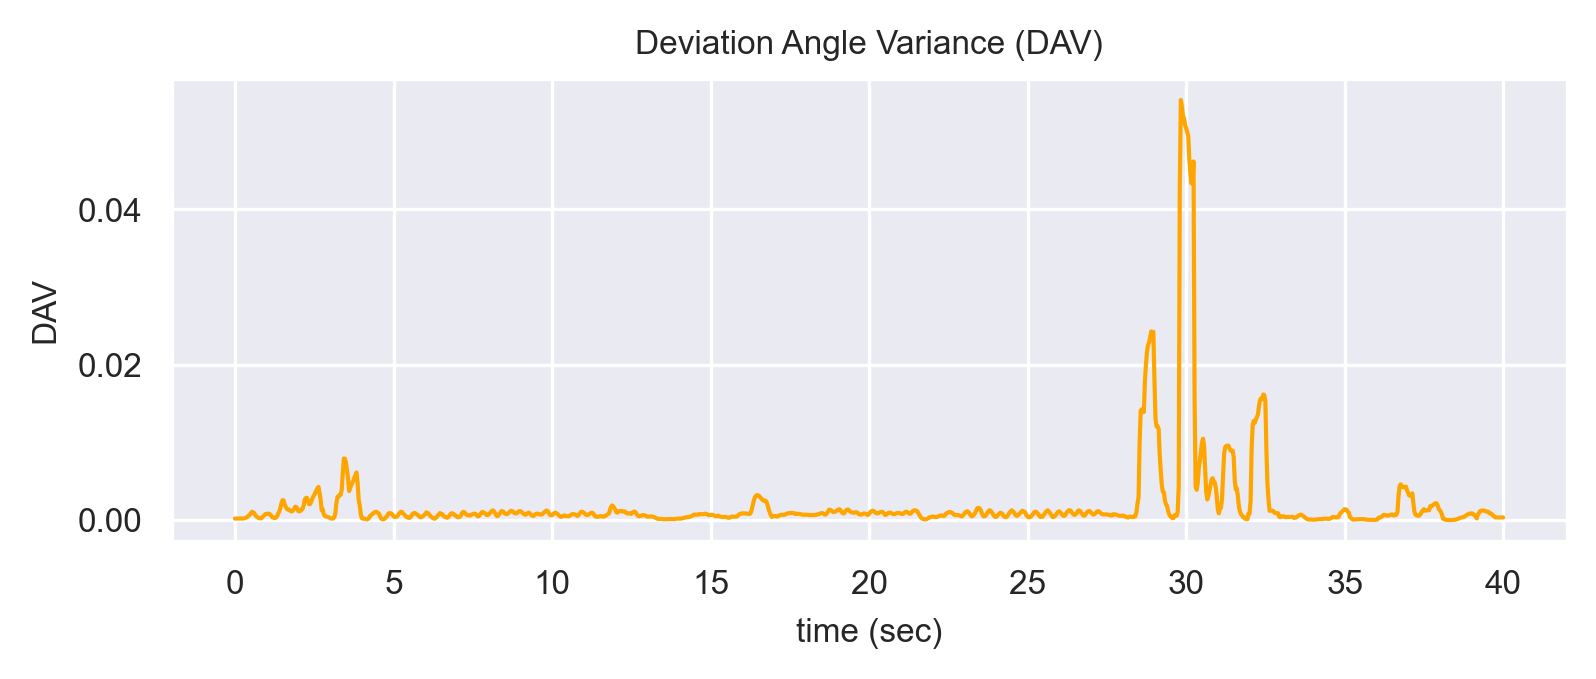

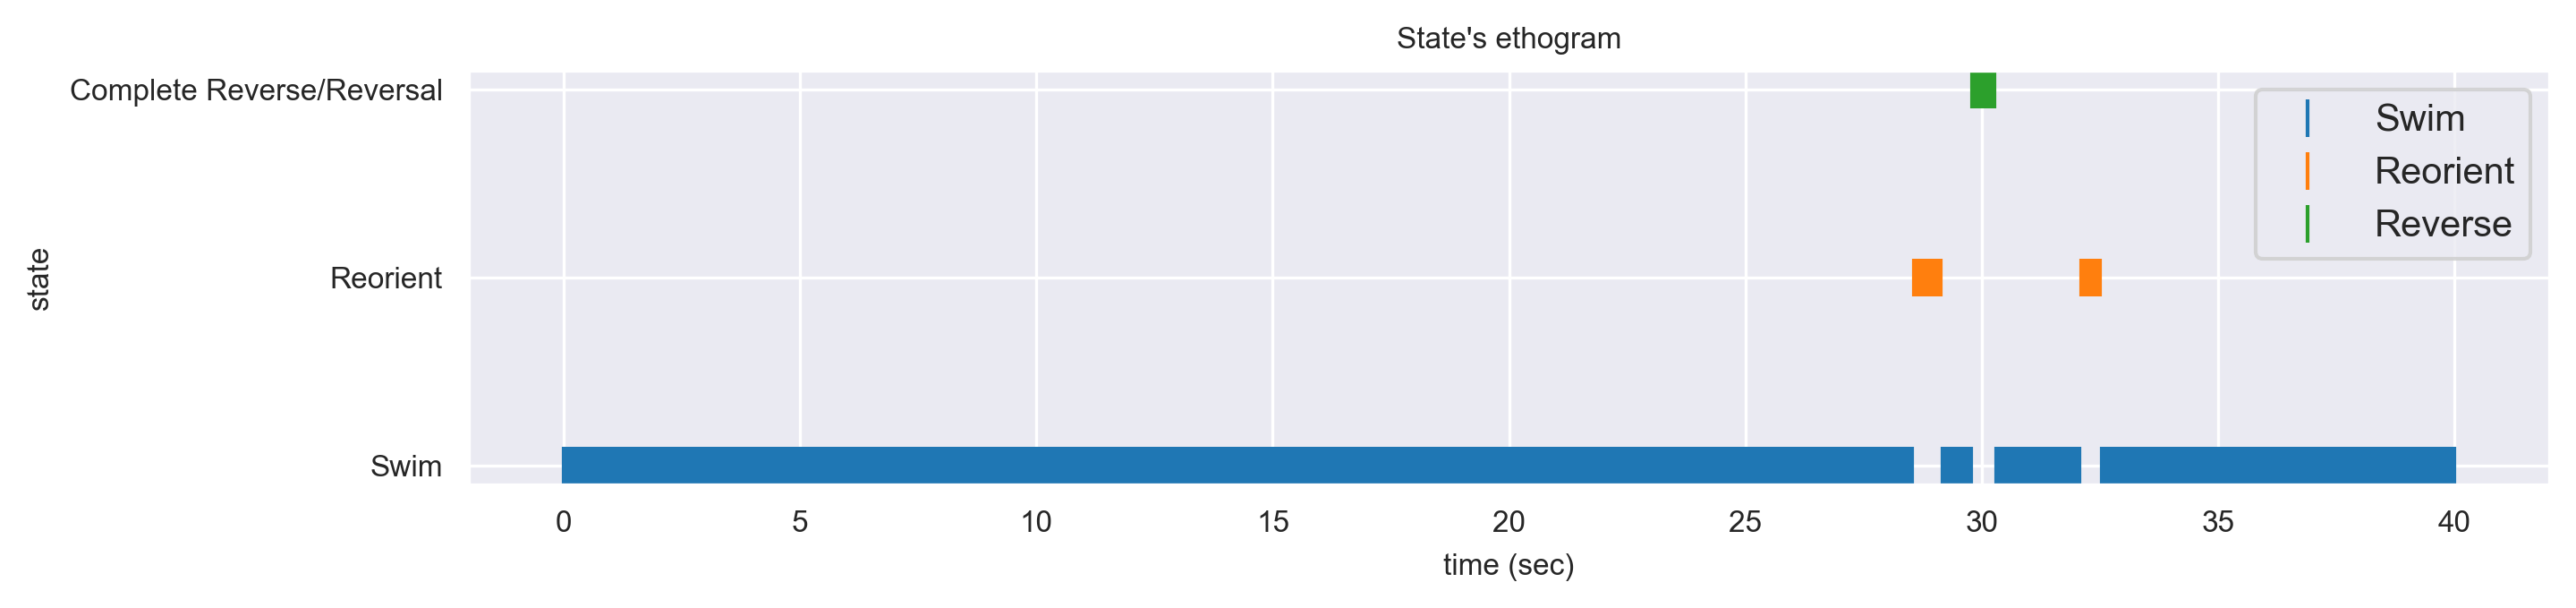

CSV saved to: W:\Users\Daphne\Imaging_Daphne\25-12-19_RPi_ptetwt_swimming_deciliated\bgd_subs_4000\processed_251219_etoh_allcilia_3_analysis\


In [41]:
# Swim → Reorient → Swim
# or
# Swim → Reverse → Swim
# but never Reorient → Reverse or Reverse → Reorient directly

# --- Thresholds ---
threshold_dav1 = 0.01
threshold_dav2 = 0.04
merge_gap = 10  # max gap (in frames) to merge close bouts

# --- Optional smoothing of dav ---
# dav_smooth = gaussian_filter1d(dav, sigma=2)
# OR use raw dav:
dav_smooth = dav

# Plot smoothed DAV
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(time_axis_sec_with_0, dav_smooth, label='Smoothed DAV', color='orange', linewidth=1)
plt.title("Deviation Angle Variance (DAV)", fontsize=fontsize_1)
plt.ylabel("DAV", fontsize=fontsize_1)
plt.xlabel("time (sec)", fontsize=fontsize_1)
plt.xticks(fontsize=fontsize_1)
plt.yticks(fontsize=fontsize_1)
plt.grid(True)
plt.savefig(output_path + "dav_smooth_in_time.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# --- State classification ---
# 0 = Swim, 1 = Reorient, 2 = Reverse
cond_Reorient = (dav_smooth >= threshold_dav1) & (dav_smooth < threshold_dav2) #& (velocity_variance > threshold_vv)
cond_Reverse = (dav_smooth >= threshold_dav2) #& (velocity_variance > threshold_vv)
states = np.select([cond_Reorient, cond_Reverse], [1, 2], default=0)

# --- Helper functions ---
# When a Reorient (1) and Reverse (2) are directly next to each other, they should be merged into a single Reverse (2) state.
def merge_Reorient_Reverse_to_Reverse(states):
    """
    When Reorient (1) and Reverse (2) are adjacent, merge both into Reverse (2).
    """
    states = states.copy()
    i = 0
    while i < len(states) - 1:
        if (states[i] in [1, 2]) and (states[i + 1] in [1, 2]) and (states[i] != states[i + 1]):
            # Find start of the contiguous 1-2 or 2-1 segment
            start = i
            while start > 0 and states[start - 1] in [1, 2]:
                start -= 1

            # Find end of the contiguous 1-2 or 2-1 segment
            end = i + 1
            while end < len(states) - 1 and states[end + 1] in [1, 2]:
                end += 1

            # Convert all to Reverse (2)
            states[start:end + 1] = 2
            i = end + 1
        else:
            i += 1
    return states


def merge_short_gaps(states, target_state, gap_max_len=10):
    """
    Fill short Swim (0) gaps between bouts of the same target_state.
    """
    states = states.copy()
    i = 0
    while i < len(states):
        if states[i] == target_state:
            # Find end of current bout
            start = i
            while i < len(states) and states[i] == target_state:
                i += 1
            end = i

            # Look ahead for a short gap followed by same state
            gap_start = i
            while i < len(states) and states[i] == 0:
                i += 1
            gap_end = i

            if i < len(states) and states[i] == target_state:
                if (gap_end - gap_start) <= gap_max_len:
                    states[gap_start:gap_end] = target_state
        else:
            i += 1
    return states

def remove_short_states(states, min_len=6):
    """
    Convert short bouts of Reorient (1) or Reverse (2) into Swim (0) if their duration < min_len frames.
    """
    states = states.copy()
    i = 0
    while i < len(states):
        current_state = states[i]
        if current_state in [1, 2]:
            start = i
            while i < len(states) and states[i] == current_state:
                i += 1
            end = i
            if (end - start) < min_len:
                states[start:end] = 0
        else:
            i += 1
    return states

# --- Apply cleaning ---
states = merge_Reorient_Reverse_to_Reverse(states)
states = merge_short_gaps(states, target_state=1, gap_max_len=merge_gap)
states = merge_short_gaps(states, target_state=2, gap_max_len=merge_gap)
# Remove short Reorient/Reverse bouts (≤ 5 frames)
states = remove_short_states(states, min_len=6)


# --- Optional final smoothing (use with care) ---
# states = median_filter(states, size=5)

# --- State names ---
state_labels = np.array(["Swim", "Reorient", "Reverse"])
state_names = state_labels[states]

# --- Plotting ethogram ---
plt.figure(figsize=(10, 2), dpi=300)

for i, label in enumerate(state_labels):
    mask = states == i
    plt.plot(time_axis_sec_with_0[mask], states[mask], linestyle='None', marker='|',
             markersize=10, label=label)

plt.title("State's ethogram", fontsize=fontsize_1)
plt.ylabel("state", fontsize=fontsize_1)
plt.xlabel("time (sec)", fontsize=fontsize_1)
plt.xticks(fontsize=fontsize_1)
plt.yticks([0, 1, 2], ["Swim", "Reorient", "Complete Reverse/Reversal"], fontsize=fontsize_1)
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig(output_path + "state_ethogram_colored.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# --- Export to CSV ---
df_states = pd.DataFrame({
    "time_sec": time_axis_sec_with_0,
    "dav": dav,
    "x":smoothed_x,
    "y":smoothed_y,
    "velocity": speed_cell_smooth,
    "state": states,
    "state_label": state_names
})

output_path2 = "W:\\Users\\Daphne\\WT_RESULTS\\WT_swimming\\States\\"

df_states.to_csv(output_path + npy_file[:-4] + sample_nr + "_states_timeseries.csv", index=False)
print(f"CSV saved to: {output_path}")
